In [21]:
import time
import base64
import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from cryptography.hazmat.primitives import serialization, hashes
from cryptography.hazmat.primitives.asymmetric import padding
from google.colab import userdata


In [22]:

def kalshi_headers(method: str, path: str) -> dict:
    api_key = userdata.get("KALSHI_API_KEY")
    private_key_pem = userdata.get("KALSHI_PRIVATE_KEY")

    timestamp = str(int(time.time() * 1000))
    message = f"{timestamp}{method}{path}"

    private_key = serialization.load_pem_private_key(
        private_key_pem.encode(), password=None
    )

    signature = base64.b64encode(
        private_key.sign(
            message.encode(),
            padding.PSS(
                mgf=padding.MGF1(hashes.SHA256()),
                salt_length=padding.PSS.DIGEST_LENGTH,
            ),
            hashes.SHA256(),
        )
    ).decode()

    return {
        "KALSHI-ACCESS-KEY": api_key,
        "KALSHI-ACCESS-SIGNATURE": signature,
        "KALSHI-ACCESS-TIMESTAMP": timestamp,
    }


In [23]:
def fetch_belief_trace(
    series_ticker: str,
    market_ticker: str,
    start_ts: int,
    end_ts: int,
    interval_minutes: int = 60,
) -> pd.DataFrame:
    """
    Fetch historical belief trace for a Kalshi market.
    interval_minutes must be one of: 1, 5, 15, 60, 1440
    """

    path = (
        f"/trade-api/v2/series/{series_ticker}"
        f"/markets/{market_ticker}/candlesticks"
    )

    url = (
        f"https://api.elections.kalshi.com{path}"
        f"?start_ts={start_ts}"
        f"&end_ts={end_ts}"
        f"&period_interval={interval_minutes}"
    )

    headers = kalshi_headers("GET", path)
    resp = requests.get(url, headers=headers)

    if resp.status_code != 200:
        raise RuntimeError(resp.text)

    candles = resp.json().get("candlesticks", [])

    if not candles:
        raise ValueError(
            f"No candlesticks returned for {market_ticker} "
            f"in window {start_ts} → {end_ts}"
        )

    df = pd.DataFrame([{
        "time": datetime.datetime.fromtimestamp(c["end_period_ts"]),
        "price": c["price"]["close_dollars"] if c["price"]["close"] else None,
        "volume": c["volume"],
        "open_interest": c["open_interest"],
    } for c in candles])

    return df.sort_values("time").reset_index(drop=True)


In [24]:
def save_belief_trace(df: pd.DataFrame, name: str):
    path = Path(f"/content/{name}.csv")
    df.to_csv(path, index=False)
    print(f"Saved belief trace → {path}")


In [26]:
def list_all_markets(series_ticker: str):
    url = "https://api.elections.kalshi.com/trade-api/v2/markets"
    params = {
        "series_ticker": series_ticker
    }

    resp = requests.get(url, params=params)
    if resp.status_code != 200:
        raise RuntimeError(resp.text)

    return resp.json().get("markets", [])


In [27]:
markets = list_all_markets("KXCUOMODROPOUT")

for m in markets:
    print(
        f"{m['ticker']} | {m['title']} | "
        f"Status: {m['status']} | "
        f"Resolved: {m.get('close_time')}"
    )


KXCUOMODROPOUT-25-CSIL | Will Curtis Sliwa drop out of the NYC Mayoral race? | Status: finalized | Resolved: 2025-11-04T04:59:00Z
KXCUOMODROPOUT-25-EADA | Will Eric Adams drop out of the NYC Mayoral race? | Status: finalized | Resolved: 2025-09-28T18:29:05.693435Z
KXCUOMODROPOUT-25 | Will Andrew Cuomo drop out of the NYC Mayoral race? | Status: finalized | Resolved: 2025-11-04T04:59:00Z


In [29]:
# Resolution time
end_ts = int(datetime.datetime(2025, 11, 4).timestamp())

# Look 60 days before resolution
start_ts = end_ts - 60 * 24 * 60 * 60

df = fetch_belief_trace(
    series_ticker="KXCUOMODROPOUT",
    market_ticker="KXCUOMODROPOUT-25",
    start_ts=start_ts,
    end_ts=end_ts,
    interval_minutes=60   # 1 hour
)

save_belief_trace(
    df,
    "belief_trace__kalshi__cuomo"
)


Saved belief trace → /content/belief_trace__kalshi__cuomo.csv


In [30]:
# Load belief trace
df = pd.read_csv(
    "/content/belief_trace__kalshi__cuomo.csv",
    parse_dates=["time"]
)

df = df.sort_values("time").reset_index(drop=True)
df.head()


,time,price,volume,open_interest
0,2025-09-05 00:00:00,NaN,0,96876
1,2025-09-05 01:00:00,NaN,0,96876
2,2025-09-05 02:00:00,0.05,205,96876
3,2025-09-05 03:00:00,0.05,238,96876
4,2025-09-05 04:00:00,NaN,0,96876


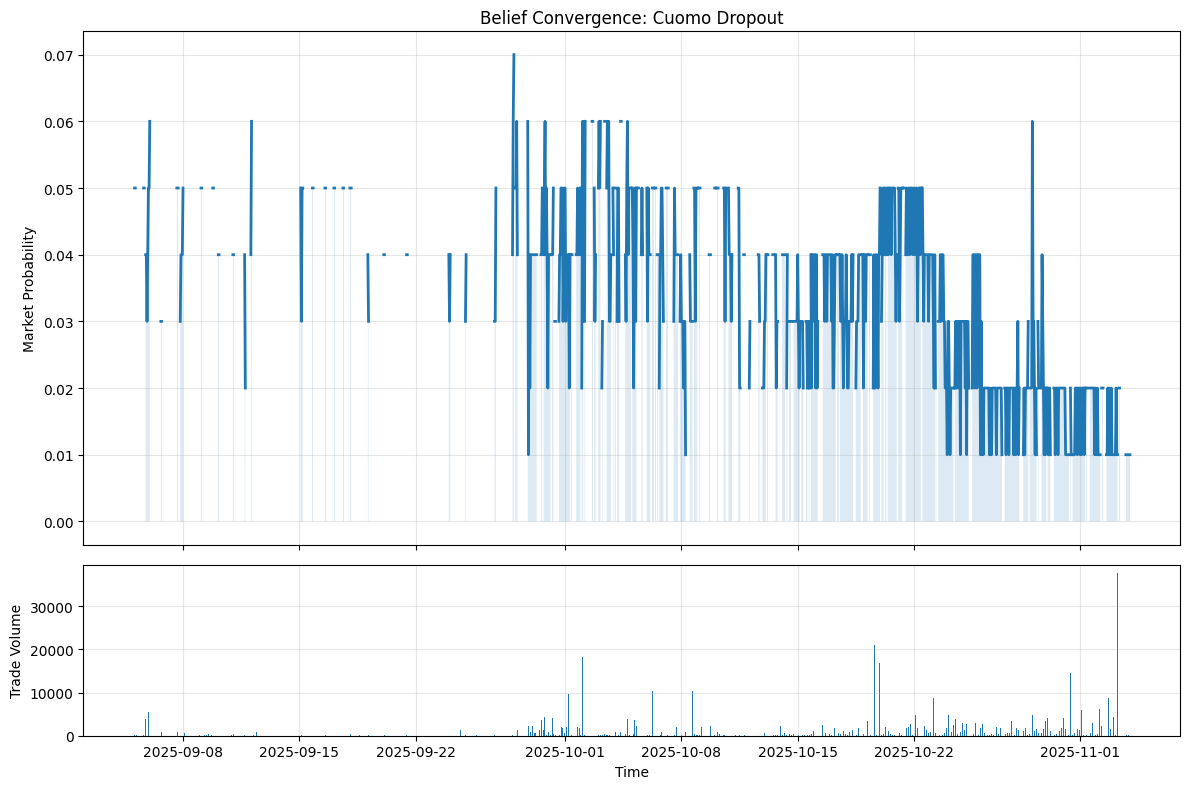

In [33]:
fig, (ax1, ax2) = plt.subplots(
    2, 1,
    figsize=(12, 8),
    sharex=True,
    gridspec_kw={"height_ratios": [3, 1]}
)

# --- Belief (probability) ---
ax1.plot(
    df["time"],
    df["price"],
    linewidth=2
)
ax1.fill_between(
    df["time"],
    df["price"],
    alpha=0.15
)
ax1.set_ylabel("Market Probability")
ax1.set_title("Belief Convergence: Cuomo Dropout")
ax1.grid(alpha=0.3)

# --- Activity (volume) ---
ax2.bar(
    df["time"],
    df["volume"],
    width=0.02
)
ax2.set_ylabel("Trade Volume")
ax2.set_xlabel("Time")
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [34]:
df["belief_change"] = df["price"].diff().abs()

belief_volatility = df["belief_change"].mean()
belief_max_jump = df["belief_change"].max()

belief_volatility, belief_max_jump


(np.float64(0.006411564625850341), 0.049999999999999996)

In [35]:
inactive_fraction = (df["volume"] == 0).mean()
inactive_fraction


np.float64(0.44273743016759776)

In [36]:
collapse_threshold = 0.95

collapsed = df[df["price"] >= collapse_threshold]

if not collapsed.empty:
    collapse_time = collapsed.iloc[0]["time"]
else:
    collapse_time = None

collapse_time


In [37]:
summary = {
    "num_observations": len(df),
    "belief_volatility_mean": belief_volatility,
    "belief_max_jump": belief_max_jump,
    "inactive_fraction": inactive_fraction,
    "collapse_time": collapse_time,
}

pd.Series(summary)


,0
num_observations,1432.000000
belief_volatility_mean,0.006412
belief_max_jump,0.050000
inactive_fraction,0.442737
collapse_time,NaN
